<a href="https://colab.research.google.com/github/Taejin1221/MachineLearning/blob/master/TrajectoryAugmentation/Augmentation_U-net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2, os, glob, random
import numpy as np
import pandas as pd

# Convet raw data to Image

In [3]:
# 빈 캔버스 만들기
def init() -> np.array: 
    blank = np.zeros([512,512],dtype=np.uint8)
    blank.fill(255)
    blank = cv2.resize(blank,(512,512))
  
    return blank

# Convert 0-1 Images into 0-255 Image
def drawNp(img: np.array) -> np.array:
    blank = init()
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if img[i][j] == 1 :
                blank[i][j] = 0

    return blank


# Convert csv File to Image
def map2Image(minX: float, minY: float, maxX: float, maxY: float, csv_file: pd.DataFrame) -> np.array:
    inputImage = np.zeros([512,512], dtype=np.uint8)

    for i in range(0,csv_file.shape[0]):
        x = csv_file.loc[i][0]
        y = csv_file.loc[i][1]

        # Print Dot
        mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
        mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
        inputImage[mapX][mapY] = 1

    outputImage = drawNp(inputImage)

    rotImage = np.rot90(outputImage)

    return rotImage


def map2Image_remove(minX: float, minY: float, maxX: float, maxY: float, csv_file: pd.DataFrame) -> np.array:
    inputImage = np.zeros([512,512], dtype=np.uint8)

    removeList = [ ]
    fileNum = csv_file.shape[0]
    for _ in range( int( fileNum * 0.5 ) ):
        idx = random.randint( 0, fileNum )
        while ( idx in removeList ):
            idx = random.randint( 0, fileNum )

        removeList.append( idx )

    for i in range(0, fileNum):
        if ( i in removeList ):
            continue

        x = csv_file.loc[i][0]
        y = csv_file.loc[i][1]

        # Print Dot
        mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
        mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
        inputImage[mapX][mapY] = 1

    outputImage = drawNp(inputImage)

    rotImage = np.rot90(outputImage)

    return rotImage


# Return Max and Min X,Y Coordinate Value of file
def coorMaxMin(file: pd.DataFrame) -> (float, float, float, float):
    minX, minY = (file.loc[0][0], file.loc[0][1])
    maxX, maxY = (file.loc[0][0], file.loc[0][1])
    for i in range(0,file.shape[0]):
        x = file.loc[i][0]
        y = file.loc[i][1]
        if x > maxX :
            maxX = x
        if x < minX :
            minX = x
        if y > maxY :
            maxY = y
        if y < minY :
            minY = y
    return minX, minY, maxX, maxY


# Load Image

In [4]:
############################
######## Image Load ########
############################

dataDir = "/content/drive/My Drive/Data/VirtualData"

In [5]:
SIZE = 512

os.chdir( dataDir )
files = glob.glob( '*csv' )

trainSize = int( len( files ) * 0.8 )
trainFiles, testFiles = files[ : trainSize], files[trainSize : ]

In [6]:
print( len( files ) )

66


In [7]:
X_train, Y_train = [ ], [ ]
for file in trainFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = coorMaxMin( csv_file )
	X_train.append( map2Image_remove( *maxmin, csv_file ) )
	Y_train.append( map2Image( *maxmin, csv_file ) )

X_test = [ ]
for file in testFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = coorMaxMin( csv_file )
	X_test.append( map2Image_remove( *maxmin, csv_file ) )

In [8]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))

(52, 512, 512)
(52, 512, 512)
(14, 512, 512)


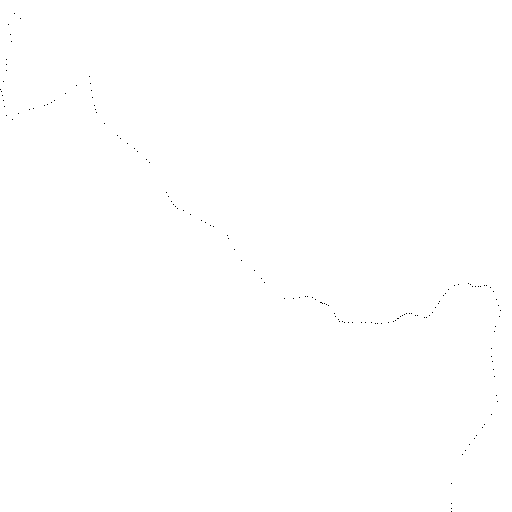

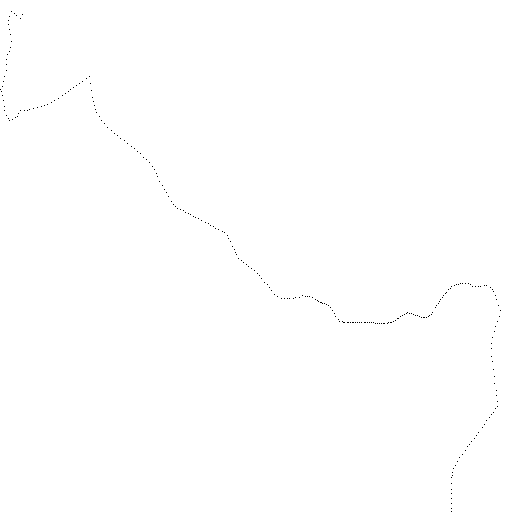

In [9]:
from google.colab.patches import cv2_imshow

cv2_imshow( X_train[0] )
cv2_imshow( Y_train[0] )

In [10]:
## Resize Images for CNN ##
X_train, Y_train = np.array( X_train ), np.array( Y_train )
X_test = np.array( X_test )

X_train = X_train.astype( 'float32' ) / 255.
Y_train = Y_train.astype( 'float32' ) / 255.
X_test = X_test.astype( 'float32' ) / 255.

print( X_train.shape, Y_train.shape, X_test.shape )

X_train = np.reshape( X_train, ( len( X_train ), SIZE, SIZE, 1 ) )
Y_train = np.reshape( Y_train, ( len( Y_train ), SIZE, SIZE, 1 ) )
X_test = np.reshape( X_test, ( len( X_test ), SIZE, SIZE, 1 ) )

print( 'train shape (X, Y): ({},{})'.format( X_train.shape, Y_train.shape ) )
print( 'test shape (X): ({})'.format( X_test.shape ) )

(52, 512, 512) (52, 512, 512) (14, 512, 512)
train shape (X, Y): ((52, 512, 512, 1),(52, 512, 512, 1))
test shape (X): ((14, 512, 512, 1))


# Constructing Model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
 ## Hyper Parameter ##
acti, pad = 'relu', 'same'

## Input Image ##
input_img = layers.Input(shape=(512, 512, 1))

# Encoding #
conv1 = layers.Conv2D( 128, ( 3, 3 ), activation = 'relu', padding = 'same' )( input_img )
pool1 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv1 )

conv2 = layers.Conv2D( 64, ( 3, 3 ),  activation = 'relu', padding = 'same' )( pool1 )
pool2 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv2 )

conv3 = layers.Conv2D( 32, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool2 )
pool3 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv3 )


# Decoding #
conv4 = layers.Conv2D( 32, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool3 )
up1 = layers.UpSampling2D( ( 2, 2 ) )( conv4 )

merge1 = layers.concatenate([conv3,up1])
conv5 = layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', padding = 'same' )( merge1 )
up2 = layers.UpSampling2D( ( 2, 2 ) )( conv5 )

#merge2 = concatenate([conv2,up2])
conv6 = layers.Conv2D( 128, ( 3, 3 ), activation = 'relu', padding = 'same' )( up2 )
up3 = layers.UpSampling2D( ( 2, 2 ) )( conv6 )


decoded = layers.Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding = 'same' )( up3 )

In [13]:
## Compile
Unet = keras.Model(input_img, decoded)
Unet.summary()

Unet.compile( optimizer = 'adam', loss = 'binary_crossentropy' )


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 73792       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [14]:
EPOCH = 30
BATCH = 10
SHUFFLE = True

history = Unet.fit( Y_train, X_train, epochs = EPOCH, batch_size = BATCH, shuffle = SHUFFLE )


Epoch 1/30
6/6 [==============================] - 1s 225ms/step - loss: 0.4052
Epoch 2/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0161
Epoch 3/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0401
Epoch 4/30
6/6 [==============================] - 1s 168ms/step - loss: 0.0347
Epoch 5/30
6/6 [==============================] - 1s 168ms/step - loss: 0.0159
Epoch 6/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0069
Epoch 7/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0052
Epoch 8/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0051
Epoch 9/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0046
Epoch 10/30
6/6 [==============================] - 1s 169ms/step - loss: 0.0043
Epoch 11/30
6/6 [==============================] - 1s 168ms/step - loss: 0.0042
Epoch 12/30
6/6 [==============================] - 1s 167ms/step - loss: 0.0041
Epoch 13/30
6/6 [==============================] 

In [15]:
decoded_img = Unet.predict( X_test )

In [16]:
print(np.shape(decoded_img))

(14, 512, 512, 1)


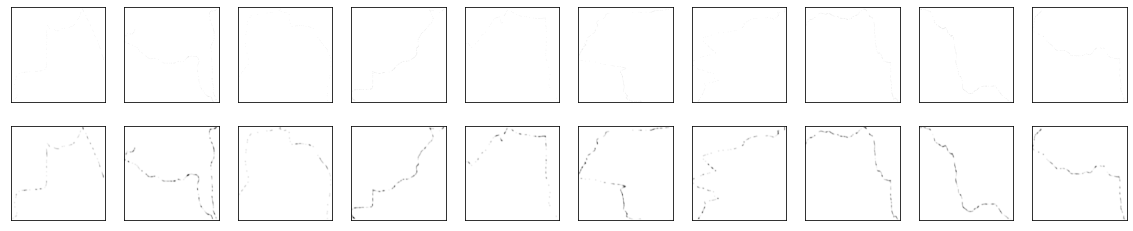

In [17]:
import matplotlib.pyplot as plt

n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test[i].reshape( SIZE, SIZE) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( decoded_img[i].reshape( SIZE, SIZE))
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.savefig( 'Result.png', dpi = 300 )
plt.show()

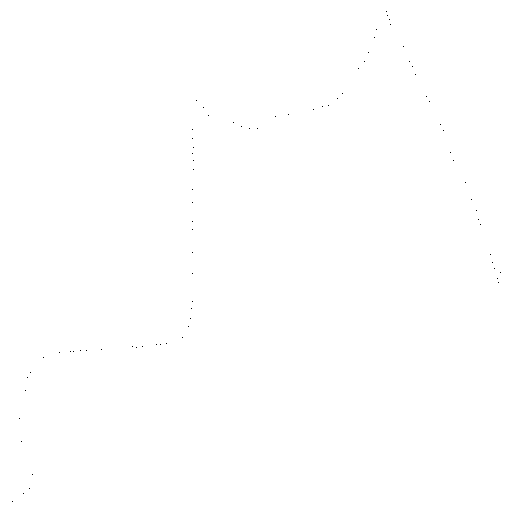

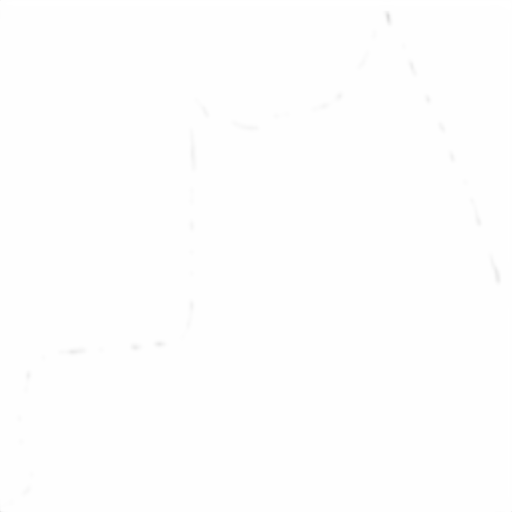

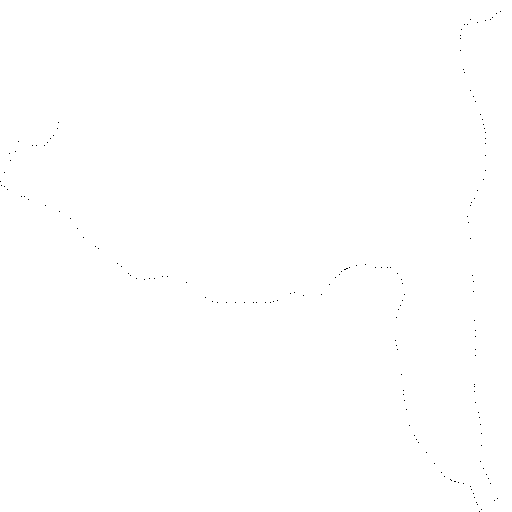

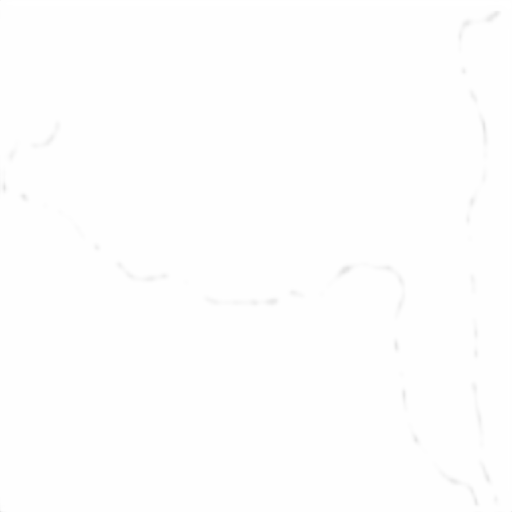

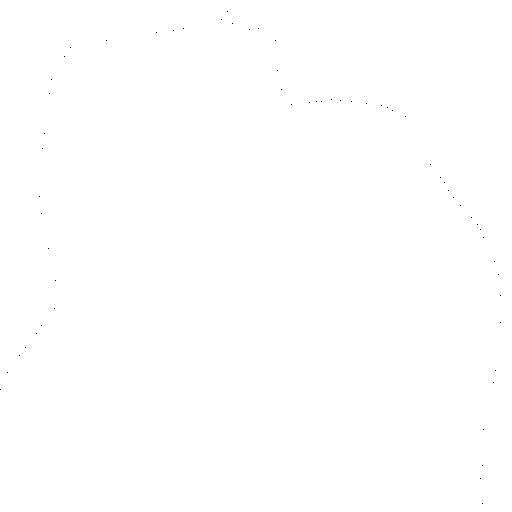

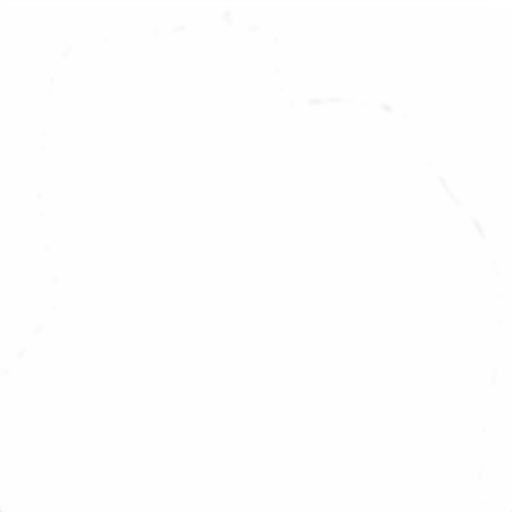

In [18]:
blank_test = np.zeros([SIZE,SIZE],dtype=np.uint8)
blank_test.fill(255)
blank_test = cv2.resize(blank_test,(SIZE,SIZE),1)

blank_predict = np.zeros([SIZE,SIZE],dtype=np.uint8)
blank_predict.fill(255)
blank_predict = cv2.resize(blank_predict,(SIZE,SIZE),1)

n = 3
for i in range( n ):
  resized_test = X_test[i].reshape(SIZE, SIZE)
  resized_predict = decoded_img[i].reshape( SIZE, SIZE )
  
  for x in range(0,SIZE):
    for y in range(0,SIZE):
      blank_test[x][y] = resized_test[x][y] * 255
      blank_predict[x][y] = resized_predict[x][y] * 255

  cv2_imshow(blank_test)
  cv2_imshow(blank_predict)